# Gradient descent - MPO class check
Created 14/05/2024

Objectives:
* Check gradient descent OOP implementation.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from functools import reduce
from operator import mul

from collections import namedtuple

import time
import pickle

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [5]:
import numpy as np
import pandas as pd
import scipy

rng = np.random.default_rng()
import matplotlib.pyplot as plt

In [6]:
import re

In [7]:
from SPTOptimization.utils import (
    get_right_identity_environment_from_tp_tensor,
    get_left_identity_environment_from_tp_tensor,
    to_npc_array,
    get_physical_dim
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.Optimizers.MPOGradientDescent import (
    MPOGradientDescent
)

# Load data

In [8]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"

In [9]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [10]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

# Definitons

In [11]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [12]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [13]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [14]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [15]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [16]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [17]:
fermionic_np_symmetries = [np_I, np_JW]

In [18]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [19]:
npc_JW = fermionic_npc_symmetries[1]

In [20]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [21]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [22]:
psi = loaded_data_triv_proj_rep[0.7]
s = symmetry_actions[0][1]

case = SymmetryActionWithBoundaryUnitaries(
    psi,
    s*40,
    left_symmetry_index=60,
    left_boundary_unitaries=[np_I, np_00]*1,
    right_boundary_unitaries=[np_00, np_I]*1
)

In [23]:
case.compute_svd_approximate_expectation()

(0.9621474575354025-0j)

In [24]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [25]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

# Test case

In [26]:
num_sites = 6

In [27]:
unitarity_learning_rate = 1
overlap_learning_rate = 100

adam_params = (5e-4, 0.3, 0.3)

In [28]:
num_seeds = 10
num_iterations = 1000

In [29]:
bond_dimension=6

In [30]:
def two_sided_mpo_expectation(symmetry_case, left_mpo_tensors,
    right_mpo_tensors):
    case = symmetry_case

    left_b_tensors = [
        case.psi.get_B(i, form='A')
        for i in range(
            case.left_symmetry_index - 1,
            case.left_symmetry_index - 1 - len(left_mpo_tensors), -1
        )
    ]

    left_b_tensors = [
        swap_left_right_indices(b)
        for b in left_b_tensors
    ]

    right_b_tensors = [
        case.psi.get_B(i)
        for i in range(
            case.right_symmetry_index + 1,
            case.right_symmetry_index + 1 + len(right_mpo_tensors)
        )
    ]

    t = right_b_tensors[-1]

    t = npc.tensordot(
        t,
        right_mpo_tensors[-1].replace_label('vL', 'vLm'),
        [['p',], ['p*']]
    )

    t = npc.tensordot(
        t,
        right_b_tensors[-1].conj(),
        [['p', 'vR'], ['p*', 'vR*']]
    )

    for b, w in zip(right_b_tensors[-2:0:-1], right_mpo_tensors[-2:0:-1]):
        t = npc.tensordot(t, b, [['vL',], ['vR']])
        t = npc.tensordot(
            t,
            w.replace_label('vL', 'vLm'),
            [['p', 'vLm'], ['p*', 'vR']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*']])

    t = npc.tensordot(t, right_b_tensors[0], [['vL',], ['vR']])
    t = npc.tensordot(
        t,
        right_mpo_tensors[0],
        [['p', 'vLm'], ['p*', 'vR']]
    )
    t = npc.tensordot(t, right_b_tensors[0].conj(), [['p', 'vL*',], ['p*', 'vR*']])
    
    
    t = npc.tensordot(
        t,
        symmetry_case.npc_symmetry_transfer_matrix,
        [['vL', 'vL*'], ['vR', 'vR*']]
    )

    t = swap_left_right_indices(t)

    t = npc.tensordot(
        t,
        left_b_tensors[0],
        [['vR',], ['vL',]]
    )

    t = npc.tensordot(
        t,
        left_mpo_tensors[0].replace_label('vR', 'vRm'),
        [['p',], ['p*',]]
    )

    t = npc.tensordot(
        t,
        left_b_tensors[0].conj(),
        [['p', 'vR*'], ['p*', 'vL*']]
    )

    for b, w in zip(left_b_tensors[1:-1], left_mpo_tensors[1:-1]):
        t = npc.tensordot(t, b, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vRm'),
            [['p', 'vRm'], ['p*', 'vL']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vR*',], ['p*', 'vL*']])

    t = npc.tensordot(t, left_b_tensors[-1], [['vR',], ['vL']])
    t = npc.tensordot(
        t,
        left_mpo_tensors[-1],
        [['p', 'vRm'], ['p*', 'vL']]
    )
    t = npc.tensordot(t, left_b_tensors[-1].conj(), [['p', 'vR*',], ['p*', 'vL*']])

    out = npc.trace(t)

    return out

In [31]:
opt = MPOGradientDescent(
    case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    adam_params,
    random_initial_mpo=True
)

In [32]:
manual_exps = list()

for _ in range(num_iterations):
    opt.grad_desc_one_step()
    manual_exps.append(opt.compute_mpo_expectation())

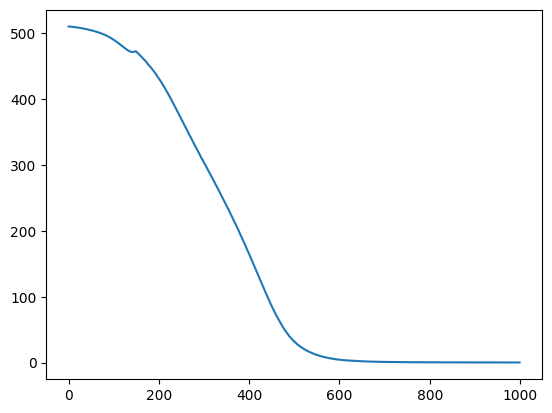

In [33]:
plt.plot(opt.unitarity_scores)

In [34]:
opt.unitarity_scores[-1]

0.19786417368618459

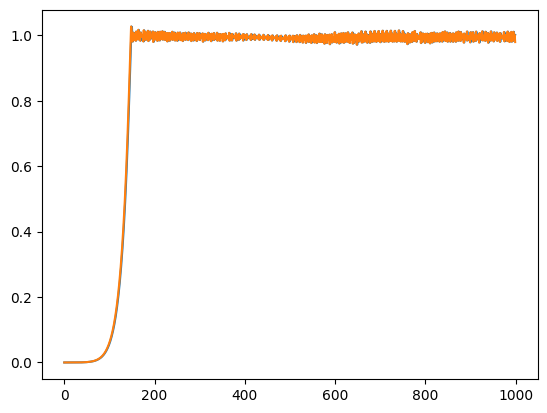

In [35]:
plt.plot(opt.mpo_expectations)
plt.plot(np.abs(np.array(manual_exps)))

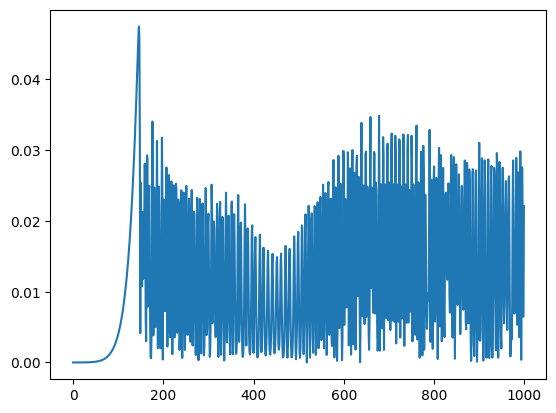

In [36]:
plt.plot(np.abs(
    np.array(opt.mpo_expectations)
    - np.abs(np.array(manual_exps))
))

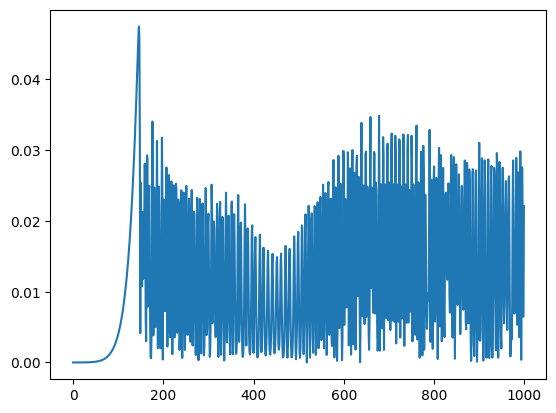

In [37]:
plt.plot(np.abs(
    np.array(opt.mpo_expectations)
    - np.abs(np.array(manual_exps))
))

In [38]:
opt.compute_training_losses()

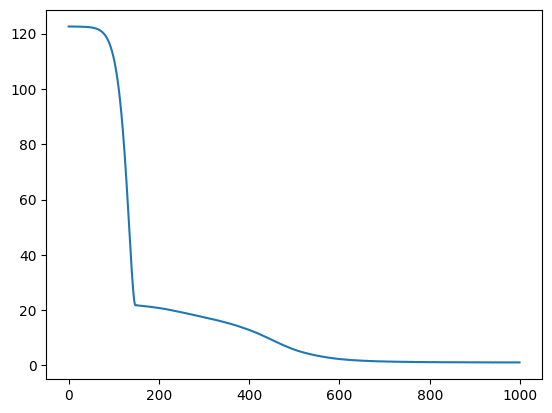

In [39]:
plt.plot(opt.training_losses)

# Conclusion
Looks good! Now need to sweep again.